# Wrangling the Xarray datasets of ERA5 data
- Creating subsets based on used grid points 
- Deriving data vars mean wind speed and wind direction
- Combining the subsetted datasets? (or treat each year separately?)

In [82]:
from pathlib import Path
from itertools import product
import math

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

#### Define path objects

In [3]:
# Directory where data files will be downloaded
cwd_path = Path.cwd()
data_path = cwd_path.parent.joinpath('data')
data_push_path = cwd_path.parent.joinpath('data_to_push')

#### Load in data

In [171]:
# Read in latest turbine data
# Now only 30,642 after removing 3 turbines outside bounding box
df = pd.read_pickle(data_push_path / 'df_turbines_knn_blades_haversine_elevation.pkl')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30642 entries, 0 to 30641
Data columns (total 30 columns):
 #   Column                                            Non-Null Count  Dtype         
---  ------                                            --------------  -----         
 0   EinheitMastrNummer                                30642 non-null  object        
 1   DatumLetzteAktualisierung                         30642 non-null  datetime64[ns]
 2   Bundesland                                        30642 non-null  object        
 3   Postleitzahl                                      30642 non-null  int64         
 4   Ort                                               30642 non-null  object        
 5   Laengengrad                                       30642 non-null  float64       
 6   Breitengrad                                       30642 non-null  float64       
 7   Registrierungsdatum                               30642 non-null  datetime64[ns]
 8   Inbetriebnahmedatum       

In [172]:
# Load the NetCDF file using Xarray
ds = xr.open_dataset(data_path.joinpath('wind_data.nc'))
ds

# Saving back to NetCDF: ds_subset.to_netcdf(data_path.joinpath('new.nc')

<xarray.Dataset>
Dimensions:    (longitude: 52, latitude: 42, time: 8760)
Coordinates:
  * longitude  (longitude) float32 4.22 4.47 4.72 4.97 ... 16.47 16.72 16.97
  * latitude   (latitude) float32 56.32 56.07 55.82 55.57 ... 46.57 46.32 46.07
  * time       (time) datetime64[ns] 2022-01-01 ... 2022-12-31T23:00:00
Data variables:
    u100       (time, latitude, longitude) float32 ...
    v100       (time, latitude, longitude) float32 ...
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-08-27 18:02:49 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

-----

## First, subset the Xarray dataset! (before deriving new data variables -> fewer calculations)
- Subset the dataset by selecting for used lat, lons

In [173]:
# Get tuples of grid points used
# 1D array of unique tuples (representing coordinate pairs)
used_grid_points = np.unique(df['nearest_grid_point'].to_numpy())
used_grid_points.shape

(755,)

In [174]:
# Since this array is 1D I need to split out the first and second elements in each tuple
# Create two separate arrays for lats and lons
lats_used = np.unique(np.array([tup[0] for tup in used_grid_points]))
lons_used = np.unique(np.array([tup[1] for tup in used_grid_points]))

In [175]:
# Now reduced to 32 lats and 38 lons
ds_subset = ds.sel(latitude=lats_used, longitude=lons_used)
ds_subset

<xarray.Dataset>
Dimensions:    (longitude: 38, latitude: 32, time: 8760)
Coordinates:
  * longitude  (longitude) float32 5.72 5.97 6.22 6.47 ... 14.47 14.72 14.97
  * latitude   (latitude) float32 47.07 47.57 47.82 48.07 ... 54.57 54.82 55.57
  * time       (time) datetime64[ns] 2022-01-01 ... 2022-12-31T23:00:00
Data variables:
    u100       (time, latitude, longitude) float32 ...
    v100       (time, latitude, longitude) float32 ...
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-08-27 18:02:49 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

---

## Derive mean wind speed at 10m data variable and add to `ds_subset`

#### Helper function to calculate wind speed using zonal and meridional components

In [178]:
def calc_wind_speed_using_ortho_components(u_zonal, v_meridional):
    """
    u_zondal (u10): wind component along local parallel of latitude; positive from west, negative from east
    v_meridional (v10): wind component along local meridian; positive from south, negative from north
    returns the magnitude of the wind vector (i.e. wind speed)
    """
    # use numpy.sqrt() as math.sqrt() only accepts scalar value not array
    mean_wind_speed = np.sqrt(u_zonal**2 + v_meridional**2)
    return mean_wind_speed

In [181]:
# Apply the function and assign to xarray dataset as a new data variable 
ds_subset['mean_wind_speed_10m'] = xr.apply_ufunc(calc_wind_speed_using_ortho_components, ds['u10'], ds['v10'])

##### Get mean wind speed at specific hour and coordinate 

In [182]:
# Example used grid point: (47.82, 10.97)
ds_subset.sel(time=['2022-01-01T00:00:00'], latitude=47.82, longitude=10.97)['mean_wind_speed_10m'].values

array([3.1660938], dtype=float32)

In [192]:
slice(360-170,360-120)

slice(190, 240, None)

In [ ]:
ds.sel(lon=slice(360-170,360-120),lat=slice(-5,5))

##### Slice on time dimension

In [194]:
# Slice out 5 hours of the data using start, stop notation
# ds_subset.sel(time=slice('2022-01-01T00:00:00', '2022-01-01T04:00:00'))

In [203]:
# This returns a bool mask as ds object!
# ds_subset.where((ds_subset.latitude > 50) & (ds_subset.longitude > 14))

In [202]:
# This returns a bool mask as ds object!
# ds_subset.where(ds_subset.latitude.isin([54.82, 55.57]))

-----

## Derive wind direction angle at 10m data variable and add to `ds_subset`

#### Calculate wind direction in degrees
- Since this isn't really a continuous variable for ML regression, also convert to descriptive categorical variable!
- Remember that the degree angle indicates where the wind blows FROM not to!
- This is the meteorological wind angle

#### Function to calculate wind direction in degrees
- Problem! Getting type error: "only length-1 arrays can be converted to Python scalars"
- Same problem as before using a method from the math module
- Solution: use the numpy equivalents!

In [183]:
def calc_wind_direction_using_ortho_components(u_zonal, v_meridional):
    """
    u_zonal and v_meridional are the magnitudes of the component vectors
    use np.arctan2 method that can take scalar values as input
    """
    # Theta is direction in radians
    theta_radians = np.arctan2(-u_zonal, -v_meridional)
    
    # Convert radians to degrees
    theta_degrees = np.degrees(theta_radians)
    
    # Normalize to compass heading convention [0, 360) if value is negative
    theta_degrees = np.where(theta_degrees < 0, theta_degrees + 360, theta_degrees)
    
    return theta_degrees

In [184]:
# Test and validate function:
u = 10
v = 2
wind_direction = calc_wind_direction_using_ortho_components(u, v)
print(f"Wind direction: {wind_direction}°")

Wind direction: 258.69006752597977°


In [185]:
# Apply the function and assign to xarray dataset as a new data variable 
ds_subset['wind_direction_angle_10m'] = xr.apply_ufunc(calc_wind_direction_using_ortho_components, ds['u10'], ds['v10'])

In [186]:
ds_subset

<xarray.Dataset>
Dimensions:                   (longitude: 38, latitude: 32, time: 8760)
Coordinates:
  * longitude                 (longitude) float32 5.72 5.97 6.22 ... 14.72 14.97
  * latitude                  (latitude) float32 47.07 47.57 ... 54.82 55.57
  * time                      (time) datetime64[ns] 2022-01-01 ... 2022-12-31...
Data variables:
    u100                      (time, latitude, longitude) float32 ...
    v100                      (time, latitude, longitude) float32 ...
    u10                       (time, latitude, longitude) float32 ...
    v10                       (time, latitude, longitude) float32 ...
    mean_wind_speed_10m       (time, latitude, longitude) float32 2.143 ... 8...
    wind_direction_angle_10m  (time, latitude, longitude) float32 158.8 ... 2...
Attributes:
    Conventions:  CF-1.6
    history:      2023-08-27 18:02:49 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

-----

### Wind direction in degrees and cardinal directions -> get hourly 

#### Function to return the inter-cardinal direction using wind direction degree angle
- For 16 inter-cardinal directions the degree range of each is:
    - 360°/16 = 22.5° (Option-Shift-8 to insert degree symbol)
    - 360°/0° is true north
    - Boundaries are 11.25° in both directions from the true direction heading
        - 0° to 11.25° is N (North)
- I'm using the following inter-cardinal directions:
    - N (North)
    - NNE (North-Northeast)
    - NE (Northeast)
    - ENE (East-Northeast)
    - E (East)
    - ESE (East-Southeast)
    - SE (Southeast)
    - SSE (South-Southeast)
    - S (South)
    - SSW (South-Southwest)
    - SW (Southwest)
    - WSW (West-Southwest)
    - W (West)
    - WNW (West-Northwest)
    - NW (Northwest)
    - NNW (North-Northwest)

In [187]:
def wind_direction_to_intercardinal(wind_direction_degrees):
    # Make sure value is between 0-360 using modulo python assignment operator %= (same as x = x % 360)
    # If 380 --> 20 degrees (starts back at 0 at 360)
    wind_direction_degrees %= 360
    
    # The 16 intercardinal direction sectors in order as they appear on compass and their corresponding ranges spanning 22.5 degrees each
    # Note: the boundaries are 11.25 in both directions from the direction's true centre line, creating sectors
    intercardinal_directions = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW', 'N']
    sector_boundaries = [11.25, 33.75, 56.25, 78.75, 101.25, 123.75, 146.25, 168.75, 191.25, 213.75, 236.25, 258.75, 281.25, 303.75, 326.25, 348.75, 360]

    # Loop through sector boundaries and return first direction at index i when condition is False
    for i in range(len(sector_boundaries)):
        # Only enter if statement once conditional is False (i.e. when wind angle is no longer less than sector boundary)
        if wind_direction_degrees < sector_boundaries[i]:
            return intercardinal_directions[i]

In [188]:
# Test and validate function:
wind_dir = 258
category = wind_direction_to_intercardinal(wind_dir)
print(f"Wind direction: {wind_dir}° is {category}")

Wind direction: 258° is WSW


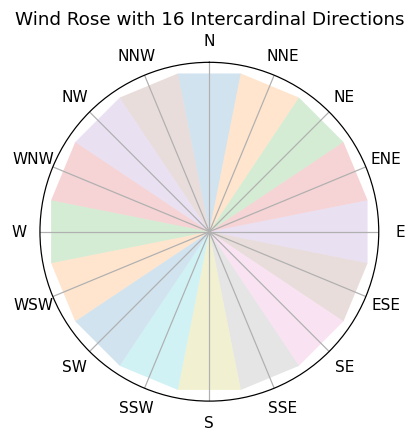

In [189]:
def plot_wind_rose():
    # Define the categories and boundaries
    categories = ["N", "NNE", "NE", "ENE", "E", "ESE", "SE", "SSE", "S", "SSW", "SW", "WSW", "W", "WNW", "NW", "NNW"]
    boundaries = np.linspace(0, 360, 17)[:-1]  # We exclude the last boundary (360) for labeling purposes

    # Set up a figure and axis with polar projection
    fig, ax = plt.subplots(figsize=(4, 4), subplot_kw={'projection': 'polar'})

    # Set the direction of azimuthal labels
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)  # Clockwise

    # Set the radius labels
    ax.set_rticks([])  # Turn off radial labels
    ax.set_rlabel_position(180)

    # Set the circular labels (directions)
    ax.set_xticks(np.radians(boundaries))
    ax.set_xticklabels(categories)

    # Plot each section with a simple color for demonstration
    for boundary in boundaries:
        ax.fill_between([np.radians(boundary-11.25), np.radians(boundary+11.25)], 0, 1, alpha=0.2)
    
    plt.title("Wind Rose with 16 Intercardinal Directions")
    plt.show()

plot_wind_rose()